In [3]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [4]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as stats
import scipy.special as ss
import sortedcontainers as sc

import tqdm
import pickle

Trying to identify whether these 100 ll jumps are real, or some type of bug

### Load libraries

In [5]:
from statsmodels.discrete.discrete_model import NegativeBinomial as statsNB

In [6]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


In [7]:
import hapaseg.coverage_DP as dp_cov
import hapaseg.a_cov_DP as dp_a_cov

In [8]:
colors = mpl.cm.get_cmap("tab20").colors

In [9]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 30

In [10]:
multidraw_df = pd.read_pickle('exome_results/acdp_df.pickle')

In [11]:
mcmc_data = np.load('exome_results/coverage_mcmc_clusters/cov_mcmc_collected_data.npz')
beta = mcmc_data['beta']

In [12]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [13]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [297]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), beta, coverage_prior=True, seed_all_clusters=True)

22.879666297402135


In [298]:
a_cov_dp.run(1)

n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([1622, 1622, 1622, ...,   -1,   -1,   -1])],
 SortedDict({33: 7060, 79: 3, 200: 1239, 568: 12120, 642: 32805, 773: 865, 1012: 5797, 1255: 67, 1479: 2144, 1494: 3524, 1585: 6266, 1587: 35195, 1590: 2486, 1591: 313, 1622: 43139, 1632: 4, 1636: 3240}))

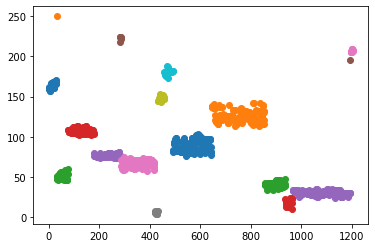

In [299]:
counter=0
for c in a_cov_dp.cluster_dict:
    vals = [np.array(a_cov_dp.segment_r_list[i]).mean() for i in a_cov_dp.cluster_dict[c]]
    plt.scatter(np.r_[counter:counter+len(vals)], vals)
    counter+= len(vals)

(array([924., 412., 120.,  69.,  11.,  14.,  10.,   4.,   6.,  12.]),
 array([ 0.09689501,  3.01739582,  5.93789663,  8.85839744, 11.77889825,
        14.69939906, 17.61989987, 20.54040069, 23.4609015 , 26.38140231,
        29.30190312]),
 <BarContainer object of 10 artists>)

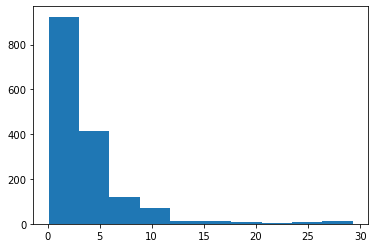

In [43]:
plt.hist(np.sqrt(np.array(a_cov_dp.segment_V_list))[mask])

In [28]:
def _scatter_apply(x, minor, major):
    f = np.zeros(len(x))
    f[x.allele == -1] = minor / (minor + major)
    f[x.allele == 1] = major / (minor + major)
    locs = x.start_g.values + (x.end_g.values - x.start_g.values)/2
    return locs, f
ADP_dict = {}
for ADP, group in a_cov_dp.cov_df.loc[a_cov_dp.cov_df.dp_draw == 0].groupby('allelic_cluster'):
    ADP_dict[ADP] = (group['maj_count'].sum(), group['min_count'].sum())

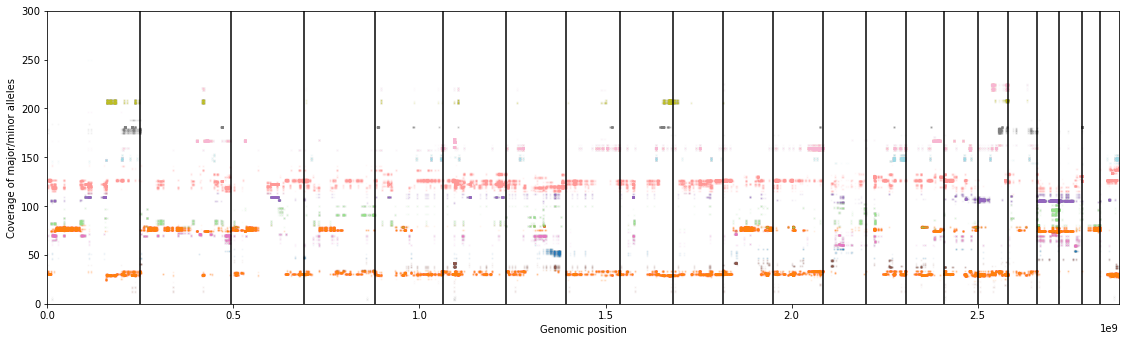

In [300]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

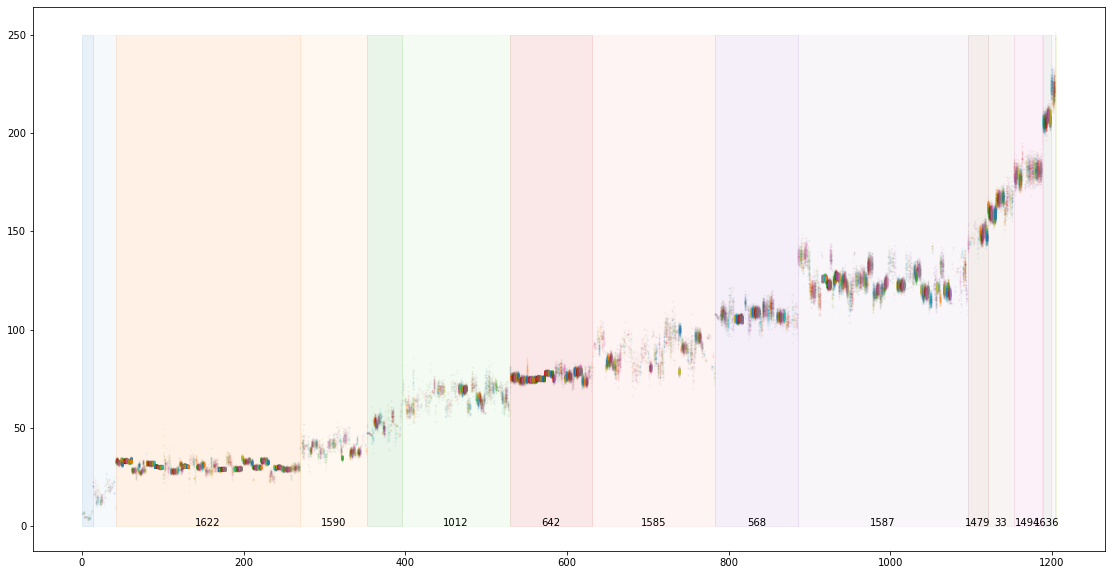

In [301]:
rs = []
for c in a_cov_dp.cluster_dict:
    rs.append((np.array([np.array(a_cov_dp.segment_r_list[i]).mean() for i in a_cov_dp.cluster_dict[c]]).mean(),c))
    
f, ax = plt.subplots(1, figsize = [19.2, 10])
counter=0
cc = 0
for c in [t[1] for t in sorted(rs)]:
    c0 = counter
    vals = [np.array(a_cov_dp.segment_r_list[i]) for i in a_cov_dp.cluster_dict[c]]
    
    for arr in vals:
        ax.scatter(np.repeat(counter, len(arr)), arr, marker = '.', alpha=0.05, s=4)
        counter+= 1
    ax.add_patch(mpl.patches.Rectangle((c0,0), counter-c0, 250, fill=True, alpha=0.10, color = colors[cc % len(colors)]))
    if a_cov_dp.cluster_counts[c]> 2000:
        ax.text(c0 + (counter-c0)/2, 0, '{}'.format(c), horizontalalignment='center')
    cc+=1

In [218]:
a_cov_dp.segment_cov_bins.mean()

102.38693467336684

In [220]:
np.median(a_cov_dp.segment_cov_bins)

31.0

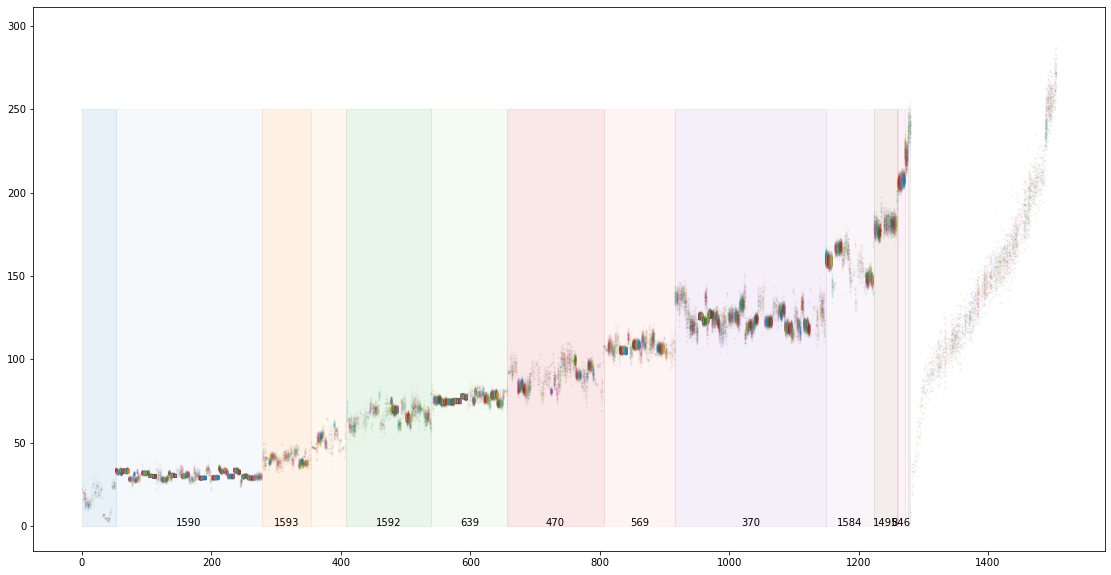

In [199]:
rs = []
for c in a_cov_dp.cluster_dict:
    rs.append((np.array([np.array(a_cov_dp.segment_r_list[i]).mean() for i in a_cov_dp.cluster_dict[c]]).mean(),c))
    
f, ax = plt.subplots(1, figsize = [19.2, 10])
counter=0
cc = 0
for c in [t[1] for t in sorted(rs)]:
    c0 = counter
    vals = [np.array(a_cov_dp.segment_r_list[i]) for i in a_cov_dp.cluster_dict[c]]
    
    for arr in vals:
        ax.scatter(np.repeat(counter, len(arr)), arr, marker = '.', alpha=0.05, s=4)
        counter+= 1
    ax.add_patch(mpl.patches.Rectangle((c0,0), counter-c0, 250, fill=True, alpha=0.10, color = colors[cc % len(colors)]))
    if a_cov_dp.cluster_counts[c]> 2000:
        ax.text(c0 + (counter-c0)/2, 0, '{}'.format(c), horizontalalignment='center')
    cc+=1

tups = sorted([(a_cov_dp.segment_r_list[seg].mean(), seg) for seg in a_cov_dp.greylist_segments])
for seg in [t[1] for t in tups]:
    arr = a_cov_dp.segment_r_list[seg]
    ax.scatter(np.repeat(counter, len(arr)), arr, marker = '.', alpha=0.05, s=4)
    counter+= 1

assign all of the greylist segments to their most likely cluster

In [280]:
[len(a_cov_dp.cluster_dict[k]) for k in a_cov_dp.cluster_dict]

[1, 44, 207, 107, 97, 5, 133, 159, 75, 27, 36, 219, 32, 10, 53]

In [282]:
[len(greylist_added_dict[k]) for k in greylist_added_dict]

[31, 52, 297, 131, 101, 16, 142, 219, 85, 45, 62, 226, 98, 24, 63]

In [302]:
self=a_cov_dp
ML_C = np.array([ML for (ID, ML) in self.cluster_MLs.items()])
greylist_added_dict = sc.SortedDict({k: v.copy() for k,v in a_cov_dp.cluster_dict.items()})
for segID in a_cov_dp.greylist_segments:
    # compute ML of S on its own
    ML_S = self._ML_cluster_from_list([segID])

    # compute ML of every cluster if S joins
    #ML_BC = np.array([self._ML_cluster(self.cluster_dict[k].union([segID]))
    #                  for k in self.cluster_counts.keys()])
    ML_BC = np.array([self._ML_cluster_add_one(k, segID) for k in self.cluster_counts.keys()])

    # likelihood ratios of S joining each other cluster S -> Ck
    ML_rat = ML_BC - ML_C

    # currently we do not support prior draws here
    # construct transition probability distribution and draw from it
    log_count_prior = self.DP_tuple_split_prior(segID)[:-1]
    MLs_max = (ML_rat + log_count_prior).max()
    choice_p = np.exp(ML_rat + log_count_prior - MLs_max) / np.exp(
        ML_rat + log_count_prior - MLs_max).sum()
    choice_idx = np.random.choice(
        np.r_[0:len(ML_rat)],
        p=choice_p
    )
    choice = np.r_[self.cluster_dict.keys()][choice_idx]
    choice = int(choice)
    greylist_added_dict[choice].add(segID)

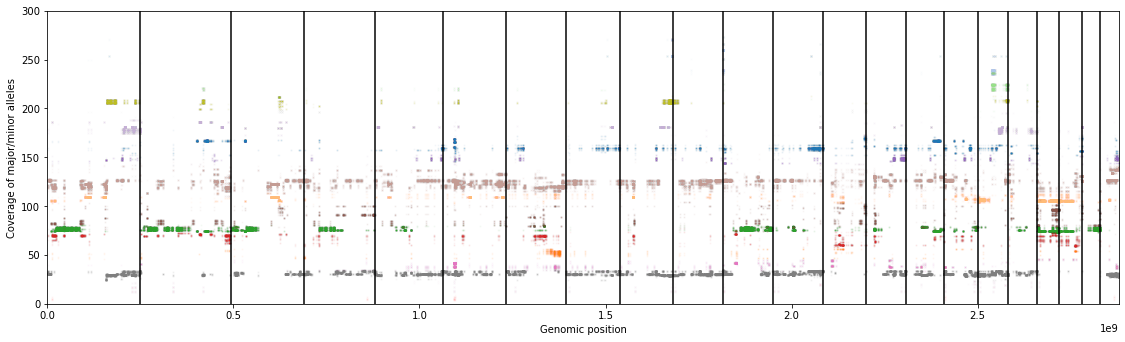

In [303]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for i, c in enumerate(a_cov_dp.cluster_dict.keys()):
    for s in greylist_added_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[i % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

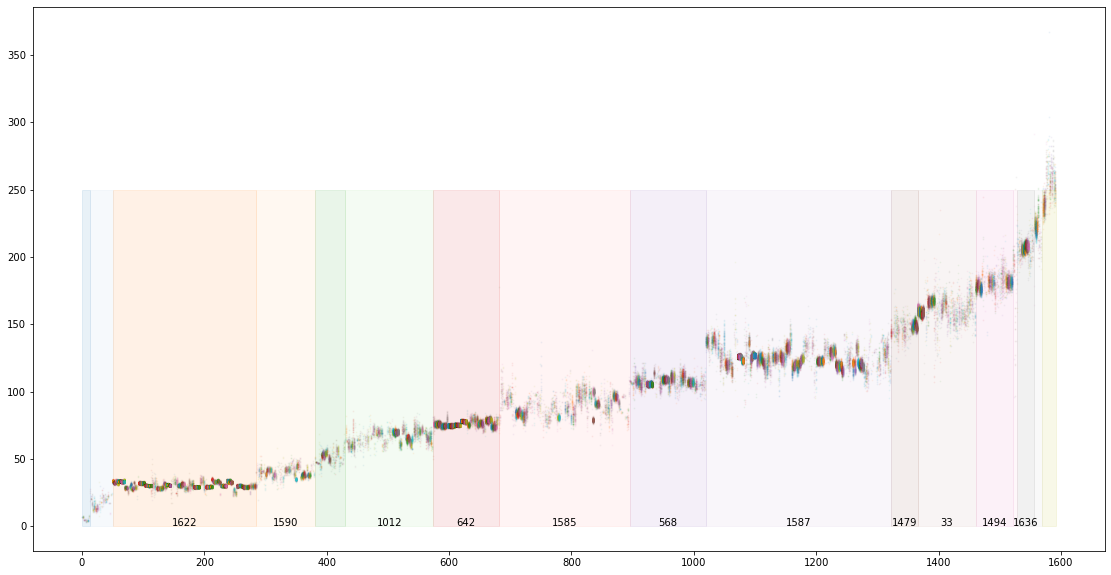

In [304]:
rs = []
for c in a_cov_dp.cluster_dict:
    rs.append((np.array([np.array(a_cov_dp.segment_r_list[i]).mean() for i in greylist_added_dict[c]]).mean(),c))
    
f, ax = plt.subplots(1, figsize = [19.2, 10])
counter=0
cc = 0
for c in [t[1] for t in sorted(rs)]:
    c0 = counter
    vals = [np.array(a_cov_dp.segment_r_list[i]) for i in greylist_added_dict[c]]
    
    for arr in vals:
        ax.scatter(np.repeat(counter, len(arr)), arr, marker = '.', alpha=0.05, s=4)
        counter+= 1
    ax.add_patch(mpl.patches.Rectangle((c0,0), counter-c0, 250, fill=True, alpha=0.10, color = colors[cc % len(colors)]))
    if a_cov_dp.cluster_counts[c]> 2000:
        ax.text(c0 + (counter-c0)/2, 0, '{}'.format(c), horizontalalignment='center')
    cc+=1

<img src="./exome_results/v4/acdp_clusters_plot.png">

<img src="./exome_results/v4/acdp_genome_plot.png">

<img src="./exome_results/v4/acdp_tuples_plot.png">

In [15]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [17]:
a_cov_dp = dp_a_cov.AllelicCoverage_DP(multidraw_df.copy(), beta, allelic_segs, seed_all_clusters=True)

22.63498180846629


In [18]:
%%prun
a_cov_dp.run(1)

n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
 

         45928488 function calls (45921823 primitive calls) in 92.780 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1446542   32.380    0.000   39.792    0.000 a_cov_DP.py:291(ML_normalgamma)
  3401823   12.667    0.000   12.667    0.000 {method 'reduce' of 'numpy.ufunc' objects}
  1596168    6.030    0.000   19.341    0.000 _methods.py:162(_mean)
  1596168    4.757    0.000    5.199    0.000 _methods.py:66(_count_reduce_items)
  1203203    4.740    0.000    4.740    0.000 {built-in method numpy.concatenate}
     2633    3.336    0.001    3.539    0.001 a_cov_DP.py:317(DP_merge_prior)
     5722    2.603    0.000    3.245    0.001 a_cov_DP.py:333(DP_tuple_split_prior)
    10694    2.520    0.000    2.872    0.000 a_cov_DP.py:310(<listcomp>)
   147630    1.895    0.000    2.805    0.000 a_cov_DP.py:359(DP_split_prior)
        1    1.655    1.655   92.780   92.780 a_cov_DP.py:399(run)
   785440    1.623    0.000   34.487  

In [31]:
tst = np.random.randint(1000,size=35000)

In [32]:
%%time
tst.mean()

CPU times: user 502 µs, sys: 10 µs, total: 512 µs
Wall time: 382 µs


499.28762857142857

In [33]:
%%time
tst.var()

CPU times: user 1.29 ms, sys: 25 µs, total: 1.32 ms
Wall time: 690 µs


83139.91369837633

In [34]:
[(c, a_cov_dp.cluster_datapoints[c].shape) for c in a_cov_dp.cluster_dict]

[(30, (7069,)),
 (79, (3,)),
 (204, (992,)),
 (364, (35245,)),
 (563, (12187,)),
 (773, (865,)),
 (1020, (5786,)),
 (1270, (67,)),
 (1480, (2142,)),
 (1500, (3519,)),
 (1584, (5229,)),
 (1591, (42831,)),
 (1601, (33812,)),
 (1615, (2877,)),
 (1642, (446,)),
 (1662, (3240,))]

In [51]:
tmp1 = a_cov_dp.cluster_datapoints[364]
tmp2 = a_cov_dp.cluster_datapoints[1591]
n1 =a_cov_dp.cluster_counts[364]
n2 = a_cov_dp.cluster_counts[1591]

sum1 = a_cov_dp.cluster_datapoints[364].sum()
sum2 = a_cov_dp.cluster_datapoints[1591].sum()

m1 = a_cov_dp.cluster_datapoints[364].mean()
m2 = a_cov_dp.cluster_datapoints[1591].mean()

var1 = a_cov_dp.cluster_datapoints[364].var()
var2 = a_cov_dp.cluster_datapoints[1591].var()

arr12 = np.concatenate([tmp1, tmp2])

In [40]:
%%time
tmp/n

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 14.1 µs


124.71824062630769

In [41]:
100e-6 * 1446542

144.6542

In [41]:
100e-6 * 1446542

144.6542

In [48]:
%%time
arr12.mean()

CPU times: user 287 µs, sys: 6 µs, total: 293 µs
Wall time: 173 µs


73.20745704981137

In [49]:
%%time
arr12.var()

CPU times: user 0 ns, sys: 1.83 ms, total: 1.83 ms
Wall time: 963 µs


2194.8300952033337

In [50]:
%%time
(sum1 + sum2) / (n1 + n2)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 14.3 µs


73.20745704981135

In [53]:
%%time
n12 = n1+n2
(n1 / (n12)) * var1 + (n2 / (n12)) * var2 + n1*n2 / n12**2 * (m1-m2)**2

CPU times: user 45 µs, sys: 1 µs, total: 46 µs
Wall time: 48.6 µs


2194.830095203334